### Extrae todos los archivos desde zip y los deja en una carpeta de salida

In [1]:
import zipfile
import os
from dotenv import load_dotenv

#lista de uso para recopilar la información
path=[]
nombre=[]
carpeta=[]
files=[]


#load all enviroment variables from filev
%load_ext dotenv
%dotenv ./env_variables/.env
load_dotenv()

#se especifica la ruta
ruta = os.environ['ruta_totalArchivos']
outputFolder = os.environ['ruta_totalSalida']

#lectura de archivos y extracción de archivos.

listaFiles= os.listdir(ruta)
for file in listaFiles:
    if zipfile.is_zipfile(ruta +'/' +file):
        with zipfile.ZipFile(ruta +'/' +file, mode="r") as archive:
            archive.extractall(outputFolder+'/')

UsageError: Line magic function `%dotenv` not found.


### Realizar una primera exploración de los datos

In [111]:
# se cargan las librerias

import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv

#carga las variables de entorno desde archivo .env en carpeta env_variables
%load_ext dotenv
%dotenv ./env_variables/.env


load_dotenv()

# se cargan las ruta
ruta = os.environ['ruta_datos']

# archivos de prueba, samples
file1 ='03012024_055712_SMIO_CBI_1_348.csv'


# lectura de archivos
df1 = pd.read_csv(ruta + '/' + file1)


# espefición de columnas a rescatar del dataset 
tag1 = 'RIO_20482_CBI_15361_101.SD_CDV_16_NP'
tag2 = 'RIO_20488_CBI_15362_101.SD_CDV_15_BA'

list_columns = ['frame.number','_ws.col.Time', tag1]

# dataFrame para  sensor
df_cdv1 = df1[list_columns]

#visualizar la carga de datos en un archivo
df_cdv1.head(5)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


,frame.number,_ws.col.Time,RIO_20482_CBI_15361_101.SD_CDV_16_NP
0,1,2024-01-03 05:56:28.525693,NaN
1,2,2024-01-03 05:56:28.532209,1.0
2,3,2024-01-03 05:56:28.560647,NaN
3,4,2024-01-03 05:56:28.627036,NaN
4,5,2024-01-03 05:56:28.643350,NaN


In [112]:
# revisamos que tipos de datos son:
df_cdv1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454011 entries, 0 to 454010
Data columns (total 3 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   frame.number                          454011 non-null  int64  
 1   _ws.col.Time                          454011 non-null  object 
 2   RIO_20482_CBI_15361_101.SD_CDV_16_NP  53983 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.4+ MB


In [113]:
#realizamos una breve revisión de los datos y su distribución
df_cdv1.describe()

,frame.number,RIO_20482_CBI_15361_101.SD_CDV_16_NP
count,454011.00000,53983.000000
mean,227006.00000,0.785970
std,131061.83087,0.410152
min,1.00000,0.000000
25%,113503.50000,1.000000
50%,227006.00000,1.000000
75%,340508.50000,1.000000
max,454011.00000,1.000000


Como existen diferencias entre las cuentas de registros para; { frame.number , datos}

Entonces, revisaremos si existen valores Nan

In [114]:
#revisamos si existen valores Nan
df_cdv1.isna().sum().sort_values()

frame.number                                 0
_ws.col.Time                                 0
RIO_20482_CBI_15361_101.SD_CDV_16_NP    400028
dtype: int64

Verficamos que los valores Nan se deben a problemas de muestreo y posiblemente cuando toma la muestra rencuentra el registro vacio, Nan .Así que tomamos la decisión de solo tomar los valores disponibles y no realizar imputación o algún reemplazo de esos valores, tomando en consideración que los valores están en el rango 0 - 1.
* Se renombran las columnas
* Se convierte la columna de tiempo a date-timme

In [115]:
# Sacamos los valores Nan
df_cdv1 = df_cdv1.dropna().reset_index(drop=True)

#renombrar columnas
df_cdv1 = df_cdv1.rename(columns={"frame.number": "idx", "_ws.col.Time": "date-time", list_columns[2]:"data"})

#convertir desde objeto a data-time
df_cdv1['date-time'] = pd.to_datetime(df_cdv1['date-time'])

#obtener solo el tiempo
df_cdv1['time'] = df_cdv1['date-time'].apply( lambda x: x.time())

In [116]:
# se visualiza los cambios de tipos de datos
df_cdv1.dtypes

idx                   int64
date-time    datetime64[ns]
data                float64
time                 object
dtype: object

Solo se necesita verificar los valores entre el rango de hora de 6AM - 11 PM

In [117]:
#filtro por rango de hora.
df_cdv1 = df_cdv1.set_index('date-time').between_time('06:00', '23:00')

- se comprueba la distribución de los datos
- se comprueba sino falta ningún dato
- se comprueba el horario, primer y último registro si se encuentran en el rango.

In [118]:
print(f' distribución: {df_cdv1.data.value_counts()}')
print(f'\n suma total de valores: {df_cdv1.data.value_counts().sum()} - tamaño del dataFrame: {len(df_cdv1)}')
print(f'\n ---------------------------------------------')
print(f'primer registro: {print(df_cdv1.head(1))}')
print(f'\n ---------------------------------------------')
print(f'ultimo registro: {print(df_cdv1.tail(1))}')

 distribución: data
1.0    41582
0.0    11343
Name: count, dtype: int64

 suma total de valores: 52925 - tamaño del dataFrame: 52925

 ---------------------------------------------
                             idx  data             time
date-time                                              
2024-01-03 06:00:00.177540  8902   1.0  06:00:00.177540
primer registro: None

 ---------------------------------------------
                               idx  data             time
date-time                                                
2024-01-03 08:56:27.260832  454005   1.0  08:56:27.260832
ultimo registro: None


In [119]:
# visualizar los datos
df_cdv1.head(5)

,idx,data,time
date-time,,,
2024-01-03 06:00:00.177540,8902,1.0,06:00:00.177540
2024-01-03 06:00:00.378650,8910,1.0,06:00:00.378650
2024-01-03 06:00:00.578018,8918,1.0,06:00:00.578018
2024-01-03 06:00:00.777871,8926,1.0,06:00:00.777871
2024-01-03 06:00:00.977870,8934,1.0,06:00:00.977870


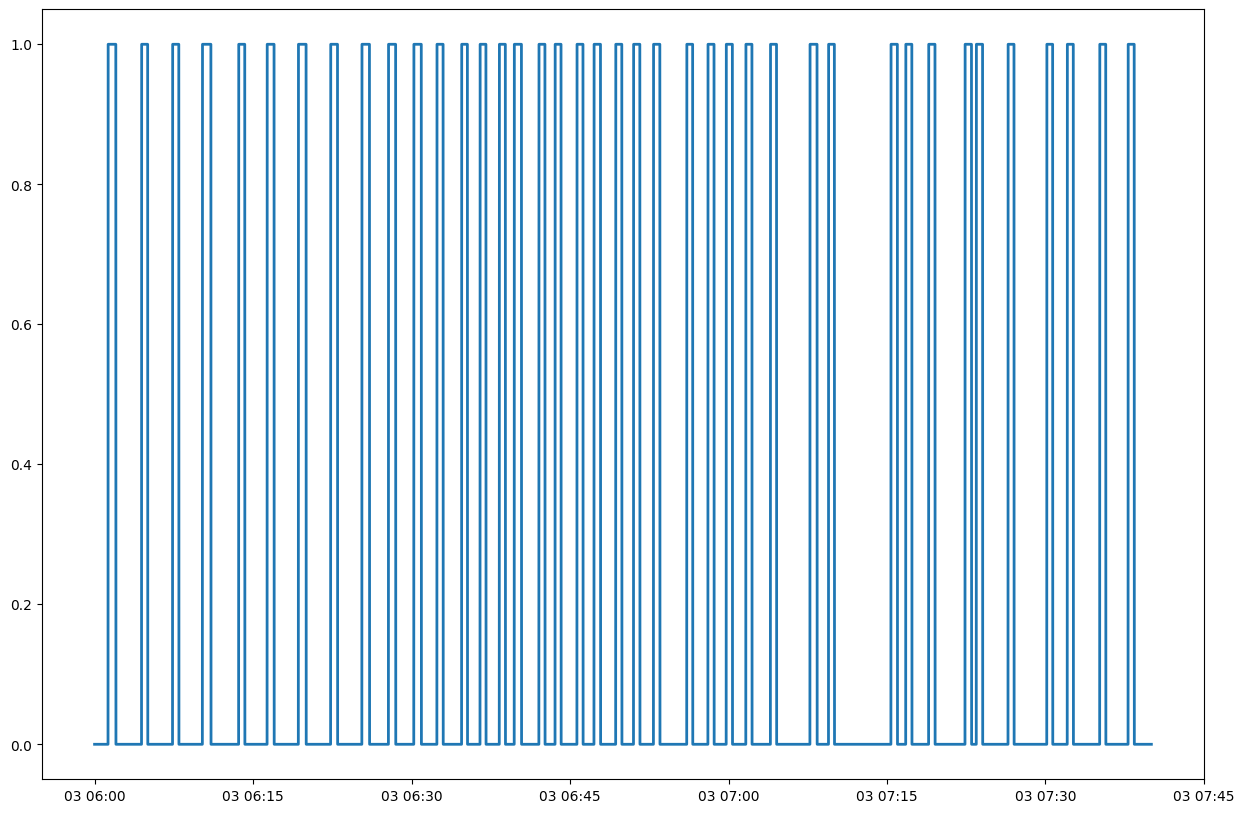

In [138]:
# visualización de los datos
# se grafica un rango de datos
data_filter = df_cdv1[0:30000]

x=data_filter.index
y=data_filter.data

fig, ax = plt.subplots(figsize=(15,10))

ax.plot(x, y, linewidth=2.0)
plt.show()


Se realiza una transformación de la señal por comodidad y se detectan los cambios de señal para identificar cuando está desocupando y por cuánto tiempo.
Se utiliza una máquina de estados para definir posiciones.

- 0: desocupado 
- 1: llegada
- 2: salida
- 3: ocupado

In [122]:
# Se convierte la señal

dataFrame = df_cdv1
dataFrame['data'] = abs(dataFrame.data - 1)

# se toma como valor inicial 
flags = [int(dataFrame.data.iloc[0])]

# se identifica la señal por estados
for x in range(1,len(dataFrame)):
    if (dataFrame.data.iloc[x] == 1 and dataFrame.data.iloc[x-1] == 0):
        flags.append(1)
    elif(dataFrame.data.iloc[x] == 0 and dataFrame.data.iloc[x-1] == 1):
        flags.append(2)
    elif(dataFrame.data.iloc[x] == 0 and dataFrame.data.iloc[x-1] == 0):
        flags.append(0)
    else:
        flags.append(3)

# se agrega columna
df_cdv1['flags'] = flags

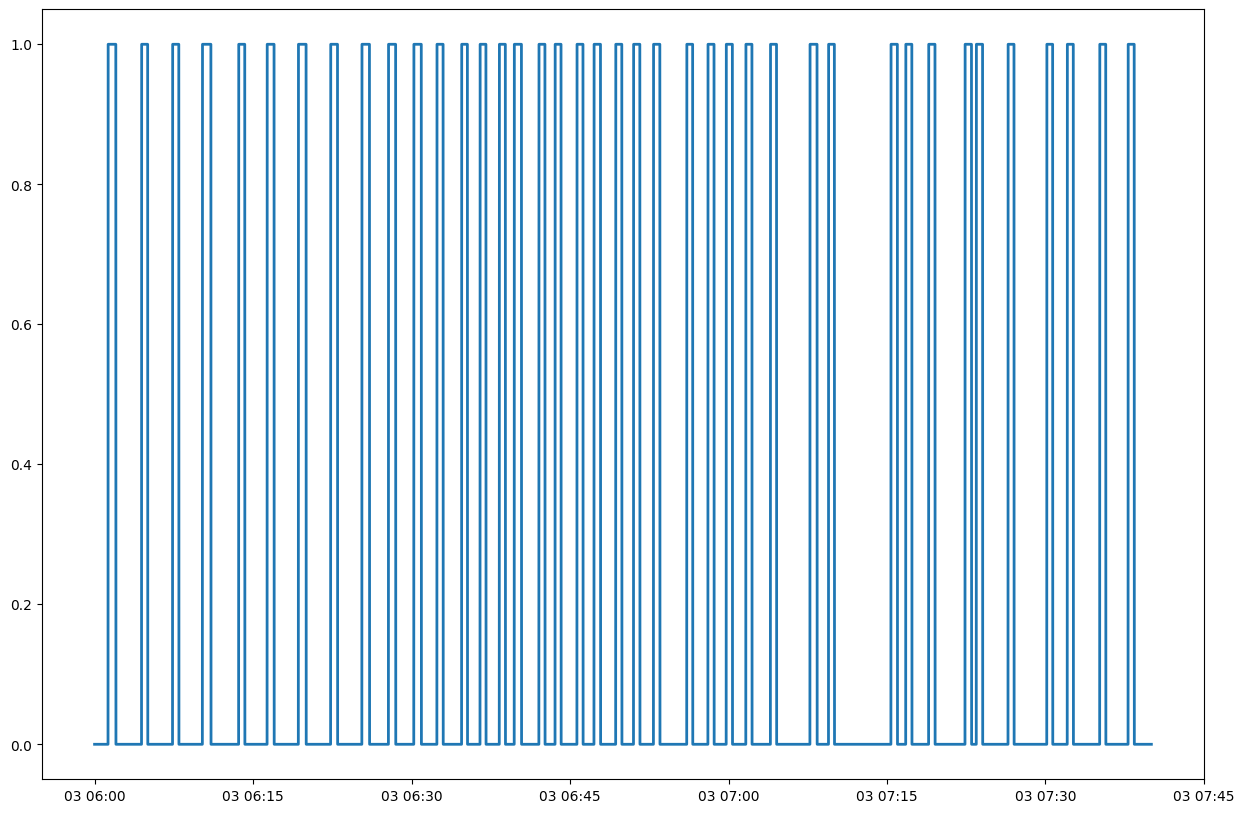

In [137]:
# visualización de los datos
# plot
data_filter = df_cdv1[0:30000]

x=data_filter.index
y=data_filter.data

fig, ax = plt.subplots(figsize=(15,10))

ax.plot(x, y, linewidth=2.0)
plt.show()

Se obtiene los datos de tiempo para obtener el tiempo de ocupación

In [124]:
timeArriving = []
timeDeparture = []
numberTrain = []
timeOcuppancy = []

# se carga dataFrame de sensor
dataFrame = df_cdv1

# se realiza la detección de los estados 1 y 2
for x in range(len(dataFrame)):
    if(dataFrame['flags'].iloc[x] == 1):
        timeArriving.append(dataFrame.index[x])
        numberTrain.append(x)
    elif(dataFrame['flags'].iloc[x] == 2):
        timeDeparture.append(dataFrame.index[x])

#Si existe diferencias entre el número flags por no inicio o termino de la señal, entonces se elimina el último.
delta = len(timeDeparture) - len(timeArriving)
if(delta < 0):
    timeArriving.pop()
    numberTrain.pop()

# se calcula el tiempo de ocupación
for y in range(len(timeDeparture)):
    deltaTime = timeDeparture[y] - timeArriving[y]
    timeOcuppancy.append(deltaTime)

# se verifica los tamaños de las columnas y también de la diferencia + o -
len(timeArriving), len(timeDeparture), len(timeOcuppancy), len(numberTrain)

(62, 62, 62, 62)

Se construye un dataFrame con las columnas de tiempo

In [125]:
timeDict = {'numberTrain': numberTrain,'timeArriving': timeArriving, 'timeDeparture':timeDeparture, 'timeOcuppancy':timeOcuppancy}
resultFrame = pd.DataFrame(timeDict)
resultFrame.head(5)

,numberTrain,timeArriving,timeDeparture,timeOcuppancy
0,383,2024-01-03 06:01:16.794358,2024-01-03 06:02:01.003493,0 days 00:00:44.209135
1,1334,2024-01-03 06:04:27.035162,2024-01-03 06:05:01.842386,0 days 00:00:34.807224
2,2214,2024-01-03 06:07:23.074629,2024-01-03 06:07:58.680536,0 days 00:00:35.605907
3,3061,2024-01-03 06:10:12.510028,2024-01-03 06:11:00.920566,0 days 00:00:48.410538
4,4090,2024-01-03 06:13:38.354803,2024-01-03 06:14:13.162325,0 days 00:00:34.807522


In [126]:
resultFrame['minutes'] = resultFrame['timeOcuppancy'] / pd.Timedelta(minutes=1)
resultFrame.head(5)

,numberTrain,timeArriving,timeDeparture,timeOcuppancy,minutes
0,383,2024-01-03 06:01:16.794358,2024-01-03 06:02:01.003493,0 days 00:00:44.209135,0.736819
1,1334,2024-01-03 06:04:27.035162,2024-01-03 06:05:01.842386,0 days 00:00:34.807224,0.580120
2,2214,2024-01-03 06:07:23.074629,2024-01-03 06:07:58.680536,0 days 00:00:35.605907,0.593432
3,3061,2024-01-03 06:10:12.510028,2024-01-03 06:11:00.920566,0 days 00:00:48.410538,0.806842
4,4090,2024-01-03 06:13:38.354803,2024-01-03 06:14:13.162325,0 days 00:00:34.807522,0.580125


In [127]:
resultFrame.describe()

,numberTrain,timeArriving,timeDeparture,timeOcuppancy,minutes
count,62.000000,62,62,62,62.000000
mean,24232.838710,2024-01-03 07:20:47.791098880,2024-01-03 07:21:24.389442816,0 days 00:00:36.598343451,0.609972
min,383.000000,2024-01-03 06:01:16.794358,2024-01-03 06:02:01.003493,0 days 00:00:33.003723,0.550062
25%,12088.000000,2024-01-03 06:40:18.299260928,2024-01-03 06:40:57.658240768,0 days 00:00:34.258282250,0.570971
50%,22816.000000,2024-01-03 07:16:04.362016,2024-01-03 07:16:40.070211584,0 days 00:00:34.807339,0.580122
75%,35734.500000,2024-01-03 07:59:08.619597824,2024-01-03 07:59:43.276333312,0 days 00:00:36.756510250,0.612609
max,52594.000000,2024-01-03 08:55:21.246811,2024-01-03 08:55:56.054545,0 days 00:00:52.415059,0.873584
std,14902.319405,NaN,NaN,0 days 00:00:04.139468210,0.068991


<function matplotlib.pyplot.show(close=None, block=None)>

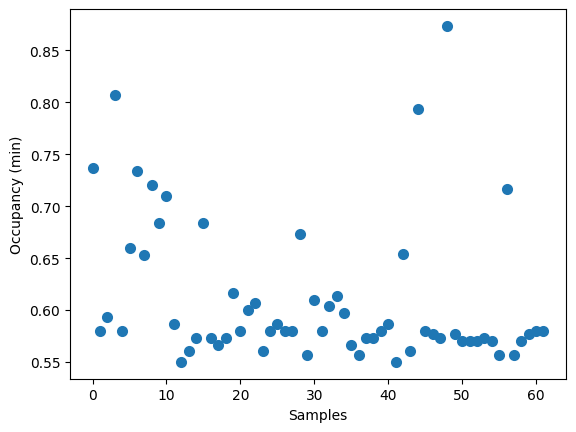

In [136]:
# plot
data_filter = resultFrame

x=data_filter.index
y=data_filter['minutes']

#figsize=(30,10)
fig, ax = plt.subplots()

ax.scatter(x, y, linewidth=2.0)
#ax.boxplot(y)

plt.xlabel('Samples') 
plt.ylabel('Occupancy (min)') 
plt.show

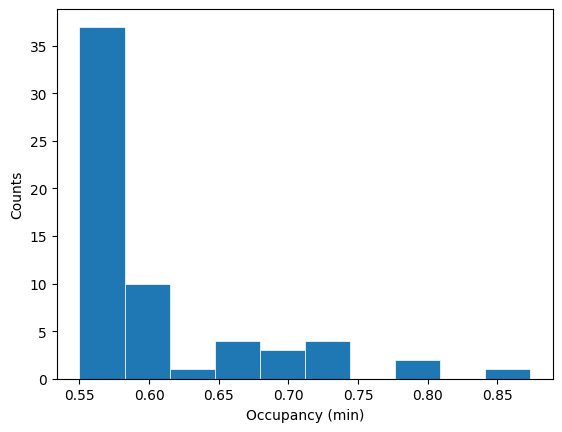

In [135]:
# plot
data_filter = resultFrame

x=data_filter.index
y=data_filter['minutes']

fig, ax = plt.subplots()

ax.hist(y, bins=10, linewidth=0.5, edgecolor="white")
plt.xlabel('Occupancy (min)') 
plt.ylabel('Counts') 
plt.show()

<Axes: ylabel='minutes'>

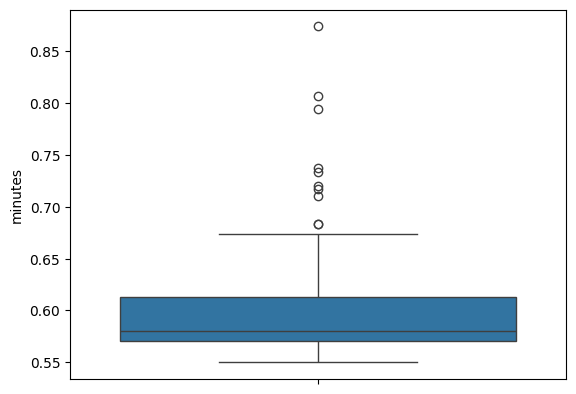

In [134]:
import seaborn as sns

# plot
data = resultFrame


sns.boxplot(data=resultFrame, y="minutes")

### Conclusiones:

- 1.- La muestra indica que existe una parada